## Librairy import

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
#%matplotlib ipympl
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp




In [2]:
frames = pims.open('C:/Users/Damien/Desktop/G3-M2Cancer/RAW/poly1µm_5/poly1µm_5_MMStack_Default.tif')
#frames = pims.open('C:/Users/Damien/Desktop/G3-M2Cancer - Copie/RAW/poly05µm_8/poly05µm_8_MMStack_Default.tif')

On peut vérifier une image du fichier chargé:

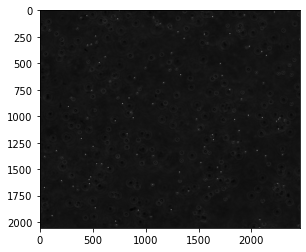

In [3]:
im=np.float32(np.array(frames))
plt.figure()
plt.imshow(im[9],cmap='gray')



## Détection des particules
Nous allons utiliser le package "trackpy" pour détecter les particules qui sont les plus brillantes dans le plan focal de l'objectif (particules blanches).
les paramètres sont les suivants:
- l'images d'intérêt (img_nb)
- diamètre des billes (en pixel - nombre impair): size_part
- invert = True pour détécter les billes sombres et non claires

In [4]:
# Define the parameters for detection
img_nb = 9 #number of the frame to test the detection
size_part=23 #size of the particles
detect = False # mode of detection (True for dark particles, False for bright ones): detect

In [5]:
f = tp.locate(im[img_nb],size_part , invert=detect)
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep
0,9.981891,1054.054326,92038.190501,6.271683,0.440343,740.750024,4109075.0,2.243043
1,10.333159,1532.918538,354634.074065,5.863504,0.343791,3148.187603,5366751.0,0.046618
2,13.121029,1810.685325,122408.941492,6.537683,0.542539,1111.125036,4344413.0,0.228500
3,15.387097,577.261649,103334.628370,5.302667,0.148353,1111.125036,4731423.0,0.092250
4,14.340845,1000.533803,131483.129288,5.877026,0.408078,1296.312542,4687819.0,0.098894


Affichage des particules détectées

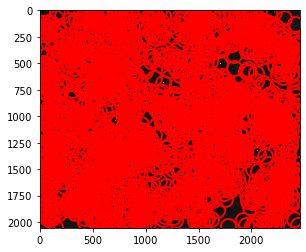

In [6]:
tp.annotate(f, im[img_nb]);

En fonction du résultats, vous pouvez ajuster les paramètres afin d'optimiser la détection des particules qui vous intéressent.
Pour pouvoir faire cela vous pouvez afficher la distribution du nombre de particules en fonction de leur poids (qui correspond à leur brillance).  

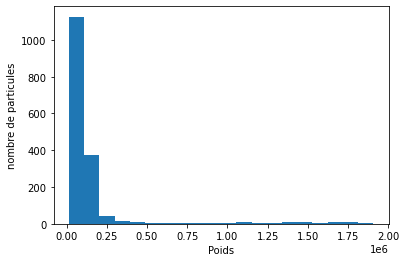

In [7]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='Poids', ylabel='nombre de particules');

Ce graphique vous donne un ordre d'idée des poids des particules et vous permet de fixer un poids seuil en dessous duquel les particules seront exclues.\
Vous pouvez ajuster le poids jusqu'à obtenir une bonne détection de vos particules.\
Rappel: vous cherchez à détecter seulement les particules les plus blanches, celles qui sont bien dans le plan focal de votre objectif, les autres particules risquent de disparaitre au cours du film et donneront seulement des trajectoires courtes.\
\
<span style="color:red"> ***Question :*** *pour quelle.s raison.s les particules peuvent-elles disparaitre?*</span>

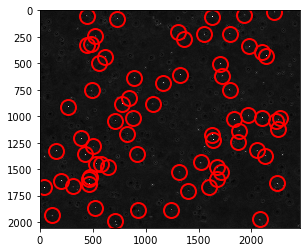

In [8]:
th_mass=1000000 # Define the threshold mass for the detection
f = tp.locate(im[img_nb],size_part,invert=detect, minmass=th_mass)
plt.figure()
tp.annotate(f, im[img_nb]);

Détection des particules dans toutes les images du film. Les positions sont stockées dans la variable f.\
Pensez à remettre les mêmes paramètres que vous avez optimisés pour la la 1ère image.

In [9]:
f = tp.batch(im[:], size_part, invert=detect, minmass=th_mass);

Frame 149: 81 features


## Génération des trajectoires
Une fois les particules détectées pour chaque image du film, vous devez maintenant reliées entre elles ces particules d'une image à l'autre de manière à obtenir la trajectoire dans le temps de chacune d'entre elles.\
Pour cela, utiliser la fonction link toujours dans le package "trackpy".\
Les paramètres sont les suivants: 
- les positions des particules détectée auparavant, stockées dans "f"
- le rayon possible dans lequel les particules peuvent se déplacer entre deux images successives. Plus ce rayon est grand plus le temps de calcul est élevé, mais si il est trop petit, vous pouvez perdre vos particules au cours du temps).
- nombre de d'images où on autorise l'algorithme à perdre la particule et la retrouver.

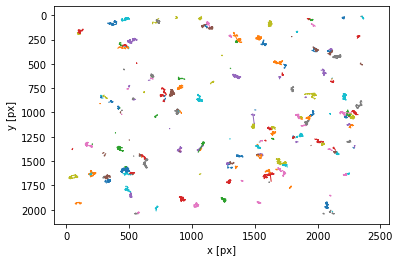

In [10]:
tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 100, memory=5)

t1=t
plt.figure()
tp.plot_traj(t1);

## Drift correction

<AxesSubplot:xlabel='frame'>

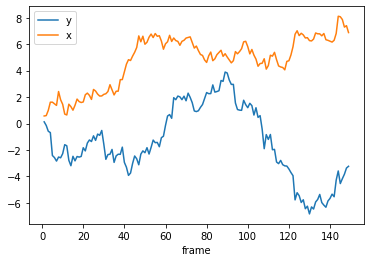

In [11]:
d = tp.compute_drift(t1)
d.plot()

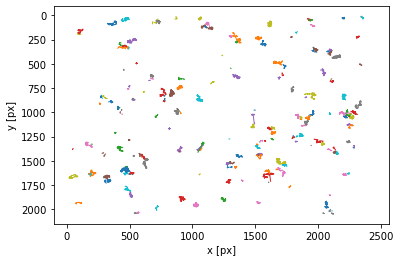

In [12]:
# Display the corrected trajectories
tp.quiet()
tm = tp.subtract_drift(t1.copy(), d)
plt.figure()
ax = tp.plot_traj(tm)

In [13]:
# Parameters of the acquisition

binning=1 # enter what binning was used
px_size = 330 # size of a pixel of the camera (µm/px)
magnification = 1040 # Magnification of the objective
FR = 10# Framerate of the acquisition (frames per second)
ima = tp.imsd(tm, binning*px_size/magnification, FR, max_lagtime=100, statistic='msd', pos_columns=None)

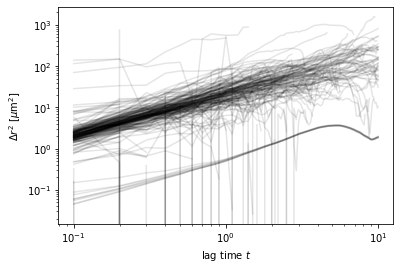

In [14]:
# Display the displacement square for all the trajectories
fig, ax = plt.subplots()
ax.plot(np.array(ima.index), np.array(ima), 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\Delta r^2$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [15]:
em = tp.emsd(tm, binning*px_size/magnification, FR)  # microns per pixel = binning*330/1040, frames per second = 10

C:\Users\Damien\anaconda3\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\Damien\anaconda3\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


C:\Users\Damien\AppData\Local\Temp\ipykernel_47908\2389596694.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=(0, 20))


[(0.07943282347242814, 20)]

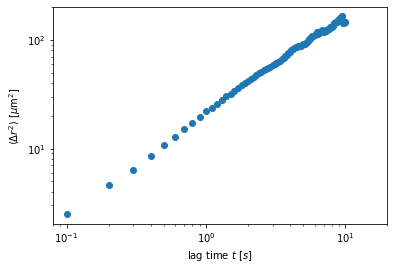

In [17]:
# Display the mean square displacement

fig, ax = plt.subplots()
ax.plot(np.array(em.index), np.array(em), 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ $[s]$')
ax.set(xlim=(0, 20))


## Fit of the MSD
The MSD is fitted with a power law function
$MSD = A*t^n$

InvalidIndexError: (slice(None, None, None), None)

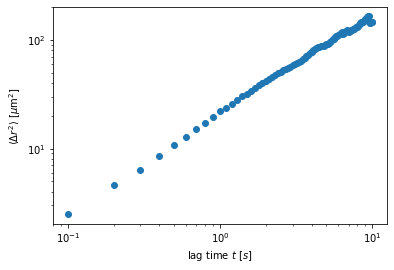

In [18]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$ $[s]$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots ()


# FIN du Notebook